In [487]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [488]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [535]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)

In [702]:
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [704]:
def prepare_bill_text_for_clean_df(bill_text_df):
    '''Prepare bill'''

def clean_bill_text(bill_text):
    bill_text_lower = bill_text.lower()
    bill_text_prepared = bill_text_lower.replace('\n', ' ') 
    return bill_text_prepared

bill_text_df['bill_text'] = bill_text_df['bill_text'].apply(prepare_bill_text)

def find_read_first_time_date(bill_text):
    '''Find first_read_date from the bill text. Bills have different formatting.'''
    try:
        bill_split = bill_text.split('first time ')[1]
        end_points = range(2, 26)
        all_datetimes = []
        for end_point in end_points:
            try:
                date = pd.Timestamp(bill_split[0:end_point])
            except:
                date = ''
            if type(date) != str:
                all_datetimes.append(date)
        date = all_datetimes[-1]
        return date
    except:
        return None    
        
bill_text_df['first_date_read'] = bill_text_df['bill_text'].apply(find_read_first_time_date)

def split_off_beginning_text(bill_text):
    try:
        return (bill_text.split('an act relating'))[1]
    except:
        return bill_text

def split_off_end_text(bill_text):
    try:
        return (bill_text.split('passed by the'))[0]
    except:
        return bill_text

bill_text_df['bill_text'] = bill_text_df['bill_text'].apply(split_off_beginning_text)
bill_text_df['bill_text'] = bill_text_df['bill_text'].apply(split_off_end_text)

In [706]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)
    
    # Create 

    return clean

In [707]:
clean = create_clean_X(merged_final_df, bill_text_df, rep_score_df)

In [708]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,index,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,33244,3,4
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,33244,3,4
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,33244,3,4
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,33244,3,4
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,33244,3,4


In [709]:
clean['vote_year'] = clean['vote_date'].apply(lambda x: x.year)

In [710]:
clean['first_year_read'] = clean['first_date_read'].apply(lambda x: x.year)

In [711]:
clean['first_year_read'] = clean['first_year_read'].fillna(clean['vote_year'])

In [712]:
clean['years_until_vote'] = clean['vote_year'] - clean['first_year_read']

In [713]:
def remove_neg(num):
    if num < 0:
        return 0
    else: return num

In [714]:
clean['years_until_vote'] = clean['years_until_vote'].apply(remove_neg)

In [715]:
clean['years_until_vote'].unique()

array([0., 1.])

In [716]:
def flip_vote(vote):
    if vote == 1:
        return 0
    if vote == 0:
        return 1
    else:
        return vote

In [717]:
clean['vote'] = clean['vote'].apply(flip_vote)

### Dummies

In [ ]:
clean_new = clean.copy()

In [ ]:
# Dummy Options
#     district_dummies = pd.get_dummies(clean_new['district'])
#     clean_dist_dum = clean_new.merge(district_dummies, right_index=True, left_index=True)

voter_id_dummies = pd.get_dummies(clean_new['voter_id'])
clean_voter_dum = clean_new.merge(voter_id_dummies, right_index=True, left_index=True)

# Make Sample

### All bienniums

In [718]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
1477678,0,2003-06-04,648,0,2003-04 SHB 2192,47842.0,2003-04,SHB 2192,http://app.leg.wa.gov/documents/billdocs/2003-...,0,...,"{1587,1543}",1543,0.500000,0.500000,3308,13,3,2003,2003.0,0.0
2299405,0,2010-02-15,8412,0,2009-10 SHB 2962,74502.0,2009-10,SHB 2962,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,"{8222,14201}",14201,0.000000,1.000000,6743,19,3,2010,2010.0,0.0
3328,1,1993-03-05,268,1,1993-94 SB 5470,12141.0,1993-94,SB 5470,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{570,564,399,25,329}",329,0.000000,1.000000,1901,3,5,1993,1993.0,0.0
998842,0,1998-02-10,1583,1,1997-98 SB 6355,29450.0,1997-98,SB 6355,http://app.leg.wa.gov/documents/billdocs/1997-...,1,...,"{1599,337,180,1583,387,475}",475,0.666667,0.333333,23584,7,6,1998,1998.0,0.0
1735310,0,2006-02-14,1570,0,2005-06 SHB 2431,56266.0,2005-06,SHB 2431,http://app.leg.wa.gov/documents/billdocs/2005-...,0,...,"{9997,10032,10021,10039,8212,5157,2149,7240,82...",619,0.090909,0.909091,5685,15,13,2006,2006.0,0.0


In [719]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [720]:
loyalty_scores_df = create_loyalty_scores_df_STEP_EIGHT(sample_train)

In [721]:
# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

In [722]:
sample_train = sample_train.drop('index', axis=1)

In [723]:
loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

In [724]:
yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

In [725]:
loy_dem_average, loy_rep_average

(-0.21704516640975166, 0.07339730155511887)

In [726]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

In [727]:
sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [728]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

In [729]:
def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

In [730]:
sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

In [731]:
sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,loyalty_score,percent_yea
0,1,2018-02-14,17226,1,2017-18 SB 6414,106557.0,2017-18,SB 6414,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.000000,1.000000,9028,27,6,2018,2018.0,0.0,-0.097515,0.076336
1,1,2018-02-10,12084,1,2017-18 SSB 6175,106111.0,2017-18,SSB 6175,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.333333,0.666667,301867,27,5,2018,2018.0,0.0,0.134222,0.135241
2,0,2018-03-05,15821,1,2017-18 SSB 6107,105962.0,2017-18,SSB 6107,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.000000,1.000000,5026,27,4,2018,2018.0,0.0,-0.170024,0.108187
3,1,2018-02-27,28022,1,2017-18 ESHB 1523,100994.0,2017-18,ESHB 1523,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.153846,0.846154,979,27,17,2018,2017.0,1.0,-0.217045,1000.000000
4,1,2018-03-05,17221,0,2017-18 EHB 2759,103272.0,2017-18,EHB 2759,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.000000,1.000000,15757,27,22,2018,2018.0,0.0,0.136123,0.169872
5,0,2018-02-10,13199,1,2017-18 SSB 6175,106111.0,2017-18,SSB 6175,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.333333,0.666667,301867,27,5,2018,2018.0,0.0,0.156098,0.072566
6,1,2018-02-14,322,1,2017-18 SB 6052,105845.0,2017-18,SB 6052,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.088235,0.911765,10749,27,20,2018,2018.0,0.0,0.027181,0.149618
7,0,2018-03-01,20755,0,2017-18 SB 6414,106557.0,2017-18,SB 6414,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.000000,1.000000,9028,27,6,2018,2018.0,0.0,-0.227306,0.041916
8,0,2018-03-02,15817,0,2017-18 SB 6136,106027.0,2017-18,SB 6136,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.250000,0.750000,2699,27,6,2018,2018.0,0.0,-0.304685,0.057737
9,0,2018-01-11,10039,0,2017-18 HB 1056,99958.0,2017-18,HB 1056,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.157895,0.842105,7809,27,23,2018,2017.0,1.0,-0.385744,0.056117


### Only 2017-18

In [ ]:
sample_one_year = clean[clean['biennium'] == '2017-18']
sample_one_year = sample_one_year[sample_one_year['vote'] <= 1]
sample_one_year.head()

In [ ]:
sample_one_year_train = sample_one_year[sample_one_year['vote_date'] < '2018-02-22T00:00:00.000000000']
sample_one_year_test = sample_one_year[sample_one_year['vote_date'] > '2018-02-22T00:00:00.000000000']

### Voter_id dummies

In [ ]:
sample_one_year_voterdum = clean_voter_dum[clean_voter_dum['biennium'] == '2017-18']
sample_one_year_voterdum = sample_one_year_voterdum[sample_one_year_voterdum['vote'] <= 1]
# X = sample_one_year_voterdum.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id', 'htm_url',
#                                    'bill_text', 'bill_num', 'bill_num_unique', 'secondary_sponsors', 
#                                    'primary_sponsor_id', 'congress_num', 'num_sponsors'], axis=1)
sample_one_year_voterdum.head()

# Modeling

### Baseline Model

In [661]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

# X_base = sample[['primary_sponsor_party', 'party']]
# y_base = sample['vote']
# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.30, random_state=709)

In [662]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [664]:
y_pred_b.max()

0.1301902187734368

In [665]:
log_loss(y_test_b, y_pred_b)

0.41473589087562923

In [666]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

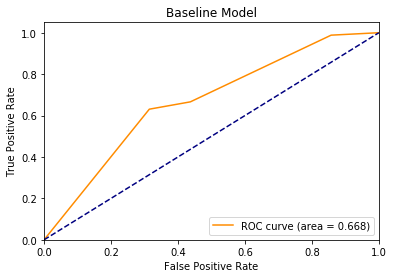

In [667]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - rep and loyalty scores

In [732]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote']]

y_test_t = sample_test['vote']

In [733]:
top_model = RandomForestClassifier(n_estimators=2000, max_depth=7, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [734]:
log_loss(y_test_t, y_pred_t)

0.3641578415844313

In [735]:
y_pred_t.max()

0.4723072374191676

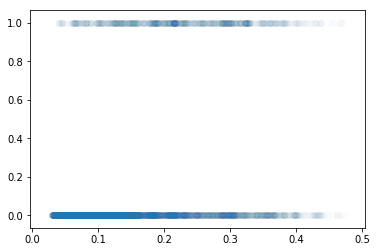

In [736]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [737]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [738]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.7895851138800174

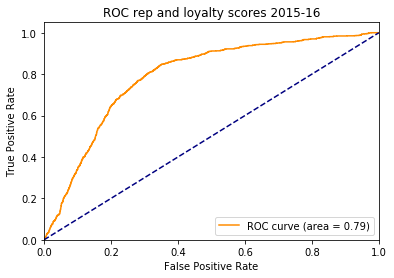

In [739]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

### NLP Playground

In [ ]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [ ]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted

### Topic Playground

In [282]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [283]:
topic_df['bill_num_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_num'].apply(str)

In [284]:
topic_df = topic_df.drop('biennium', axis=1)

In [285]:
MERGD = sample_train.merge(topic_df, how='left', on='bill_num_unique')

In [286]:
MERGD_train = MERGD[MERGD['bill_id_y'].notnull()]

In [287]:
MERGD_test = sample_test.merge(topic_df, how='left', on='bill_num_unique')

In [288]:
MERGD_test = MERGD_test[MERGD_test['bill_id_y'].notnull()]

In [289]:
# TRAIN
X_train = MERGD_train.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_y', 'bill_id_x', 'htm_url',
                                    'bill_text', 'bill_num_unique', 'secondary_sponsors', 
                                    'primary_sponsor_id', 'congress_num', 'dem_score'], axis=1)

y_train = MERGD_train['vote']

# TEST
X_test = MERGD_test.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_y', 'bill_id_x', 'htm_url',
                                    'bill_text', 'bill_num_unique', 'secondary_sponsors', 
                                    'primary_sponsor_id', 'congress_num', 'dem_score'], axis=1)

y_test = MERGD_test['vote']

In [306]:
model = RandomForestClassifier(n_estimators=3000, max_depth=6, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [307]:
log_loss(y_test, y_pred)

0.4406597647288424

In [308]:
y_pred.min()

0.7488319675217525

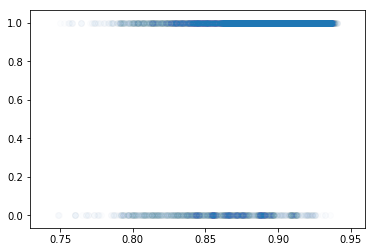

In [309]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [310]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [311]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.7635124840885809

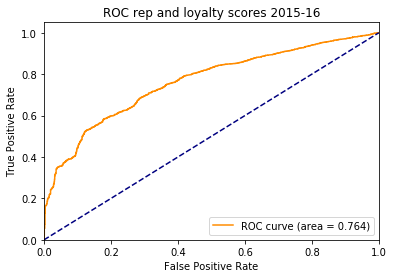

In [312]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [313]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [314]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [315]:
features_importances_sorted.head()

,0
bill_length,0.128374
rep_score,0.115128
percent_yea,0.089915
is_minority_party,0.065150
num_sponsors,0.058486


In [ ]:
group = sample_one_year.groupby('vote')

In [ ]:
group.mean()

# Model to Pickle

# Explore bill_text

In [317]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

yeas.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,index,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors
402049,1,1991-04-23,50,0,1991-92 SHB 2048,2112.0,1991-92,SHB 2048,http://app.leg.wa.gov/documents/billdocs/1991-...,0,...,2048,1991-92 2048,2108,"{46,285,32,337,410,322,325,475,406,394,304,396...",297,0.733333,0.266667,12096,1,13
2536082,1,2012-04-10,972,1,2011-12 HB 2822,82581.0,2011-12,HB 2822,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,2822,2011-12 2822,82578,None,8222,0.000000,1.000000,5043,21,1
2194989,1,2009-04-17,8159,1,2009-10 SHB 1332,71367.0,2009-10,SHB 1332,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,1332,2009-10 1332,71363,"{5160,8209,12002,10039,5157,9710,11997,14204,8...",11999,0.200000,0.800000,5474,19,12
274203,1,1996-02-05,646,0,1995-96 SHB 2163,16873.0,1995-96,SHB 2163,http://app.leg.wa.gov/documents/billdocs/1995-...,0,...,2163,1995-96 2163,16871,"{1660,1594,1592,1583}",1583,1.000000,0.000000,3030,5,5
2773335,1,2014-02-12,2142,1,2013-14 ESB 6034,91603.0,2013-14,ESB 6034,http://app.leg.wa.gov/documents/billdocs/2013-...,1,...,6034,2013-14 6034,91599,"{564,17226,8211,171,5163}",5163,0.200000,0.800000,12221,23,6


In [678]:
nays.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,index,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors
864425,0,1998-02-16,1659,0,1997-98 ESHB 2395,25134.0,1997-98,ESHB 2395,http://app.leg.wa.gov/documents/billdocs/1997-...,0,...,2395,1997-98 2395,25131,"{1593,1592,1660,654,2172,2146,1369,406,1584,15...",1868,1.0,0.0,3369,7,15
1958657,0,2003-03-03,658,0,2003-04 EHB 1369,46336.0,2003-04,EHB 1369,http://app.leg.wa.gov/documents/billdocs/2003-...,0,...,1369,2003-04 1369,46333,"{2157,651}",651,0.5,0.5,2105,13,3
843381,0,1997-04-26,1658,0,1997-98 2SHB 2054,24509.0,1997-98,2SHB 2054,http://app.leg.wa.gov/documents/billdocs/1997-...,0,...,2054,1997-98 2054,24503,"{1577,1587,648,75}",75,1.0,0.0,4482,7,5
3019702,0,2017-03-01,1649,0,2017-18 2SHB 1540,101034.0,2017-18,2SHB 1540,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1540,2017-18 1540,100942,"{13198,8215,10031,26178,8286,27504,15809,17241...",3483,0.0,1.0,8544,27,14
2492257,0,2011-03-05,15813,0,2011-12 ESHB 2002,81115.0,2011-12,ESHB 2002,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,2002,2011-12 2002,81112,"{15736,2314,9207,9997}",9997,0.0,1.0,14352,21,5


In [ ]:
Read first time
BE IT ENACTED
AN ACT

Passed the house

In [688]:
print(yeas.loc[2773335, 'bill_text'])



CERTIFICATION OF ENROLLMENTENGROSSED SENATE BILL 6034Chapter 86, Laws of 201463rd Legislature2014 Regular SessionSTATE PARKS--PARTNERSHIP OPPORTUNITIESEFFECTIVE DATE:
06/12/14Passed by the Senate
March 11, 2014  YEAS 47  &nbspNAYS 2BRAD OWEN________________________________________    President of the SenatePassed by the House
March 7, 2014  YEAS 79  &nbspNAYS 18FRANK CHOPP________________________________________    Speaker of the House of Representatives CERTIFICATEI, Hunter G. Goodman, Secretary of
the Senate of the State of
Washington, do hereby certify that
the attached is ENGROSSED SENATE
BILL 6034 as passed by the Senate
and the House of Representatives on
the dates hereon set forth.HUNTER G. GOODMAN________________________________________    SecretaryApproved March 27, 2014, 10:35 a.m.JAY INSLEE________________________________________    Governor of the State of Washington FILEDMarch 27, 2014Secretary of StateState of Washington_____________________________________________ ENGR

In [679]:
print(nays.loc[2492257, 'bill_text'])



_____________________________________________ ENGROSSED SUBSTITUTE HOUSE BILL 2002_____________________________________________State of Washington62nd Legislature2011 Regular SessionBy
House Labor & Workforce Development (originally sponsored by Representatives Sells, Ryu, Ormsby, and Kenney)READ FIRST TIME 03/05/11.
AN ACT Relating to industrial insurance employer wage subsidies and
reimbursements for light duty or transitional work; reenacting and
amending RCW 51.32.090; providing an effective date; providing an
expiration date; and declaring an emergency.BE IT ENACTED BY THE LEGISLATURE OF THE STATE OF WASHINGTON:Sec. 1
RCW 51.32.090 and 2007 c 284 s 3 and 2007 c 190 s 1 are
each reenacted and amended to read as follows:     (1) When the total disability is only temporary, the schedule of
payments contained in RCW 51.32.060 (1) and (2) shall apply, so long as
the total disability continues.     (2) Any compensation payable under this section for children not in
the custody of the 

In [701]:
bill_text_df.head()

,index,unique_id,htm_url,bill_text,first_date_read,bill_wo_beg,bill_wo_beg_and_end
0,0,8893.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to appropriations for projects recommended by...,1993-02-08,to appropriations for projects recommended by...,to appropriations for projects recommended by...
1,70,8895.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to state remembrances; and amending rcw 1.20....,1993-02-08,to state remembrances; and amending rcw 1.20....,to state remembrances; and amending rcw 1.20....
2,79,8909.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to the funding of the office of minority and ...,1993-02-10,to the funding of the office of minority and ...,to the funding of the office of minority and ...
3,120,8896.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to state remembrances; and amending rcw 1.20....,1993-03-03,to state remembrances; and amending rcw 1.20....,to state remembrances; and amending rcw 1.20....
4,127,8920.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to temporary remedies from agency action; and...,1993-02-10,to temporary remedies from agency action; and...,to temporary remedies from agency action; and...


In [683]:
def split_off_beginning_text(bill_text):
    try:
        return (bill_text.split('an act relating'))[1]
    except:
        return bill_text

def split_off_end_text(bill_text):
    try:
        return (bill_text.split('passed by the'))[0]
    except:
        return bill_text

bill_text_df_test = bill_text_df

bill_text_df_test['bill_text'] = bill_text_df_test['bill_text'].apply(split_off_beginning_text)

bill_text_df_test['bill_text'] = bill_text_df_test['bill_text'].apply(split_off_end_text)

In [700]:
bill_text_df_test

,index,unique_id,htm_url,bill_text,first_date_read,bill_wo_beg,bill_wo_beg_and_end
0,0,8893.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to appropriations for projects recommended by...,1993-02-08,to appropriations for projects recommended by...,to appropriations for projects recommended by...
1,70,8895.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to state remembrances; and amending rcw 1.20....,1993-02-08,to state remembrances; and amending rcw 1.20....,to state remembrances; and amending rcw 1.20....
2,79,8909.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to the funding of the office of minority and ...,1993-02-10,to the funding of the office of minority and ...,to the funding of the office of minority and ...
3,120,8896.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to state remembrances; and amending rcw 1.20....,1993-03-03,to state remembrances; and amending rcw 1.20....,to state remembrances; and amending rcw 1.20....
4,127,8920.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to temporary remedies from agency action; and...,1993-02-10,to temporary remedies from agency action; and...,to temporary remedies from agency action; and...
5,219,8900.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to vehicular pursuit by law enforcement offic...,1993-03-03,to vehicular pursuit by law enforcement offic...,to vehicular pursuit by law enforcement offic...
6,317,8906.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to the economic development finance authority...,1993-03-08,to the economic development finance authority...,to the economic development finance authority...
7,562,8913.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to granting temporary licenses to dental hygi...,1993-03-03,to granting temporary licenses to dental hygi...,to granting temporary licenses to dental hygi...
8,660,8935.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to authorization of the pooling of trust mana...,1993-02-10,to authorization of the pooling of trust mana...,to authorization of the pooling of trust mana...
9,809,8917.0,http://app.leg.wa.gov/documents/billdocs/1993-...,to certification of marriage and family thera...,1993-03-03,to certification of marriage and family thera...,to certification of marriage and family thera...


In [337]:
example_text = yeas.loc[402049, 'bill_text']

In [338]:
example_text = example_text.lower()

In [359]:
(example_text.split('first time')[1])[0:20]

' march 4, 1991.lower'

### TFIDFVectorizer

In [ ]:
bills = sample_one_year['bill_text']

In [ ]:
bills.shape

In [ ]:
wordnet = WordNetLemmatizer()

In [ ]:
def create_bill_tokens(bill):
    bill = bill.replace('\n', ' ') 
    punctuations = set(string.punctuation)
    
    bill = ''.join([char.lower() for char in bill if char not in punctuations])
    bill_tokens = bill.split(' ')
    lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
    return lemmed_bill

In [ ]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

In [ ]:
stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [ ]:
analyzer=create_bill_tokens, 

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.9, max_features=5000)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
vocab = tf.vocabulary_
vocab

tfidf_cols = transformed.toarray()

tfidf_names = fitted.get_feature_names()

tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

tfidf_df.head()

tfidf_df.shape

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed = tf.transform(bills)

In [ ]:
vocab = tf.vocabulary_

In [ ]:
vocab

In [ ]:
tfidf_cols = transformed.toarray()

In [ ]:
tfidf_names = fitted.get_feature_names()

In [ ]:
tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

In [ ]:
tfidf_df.head()

In [ ]:
tfidf_df.shape

In [ ]:
# cv = CountVectorizer(stop_words=stopwords_nltk, analyzer='word', ngram_range=(1, 4), max_df=0.9, max_features = 200000)
# cv_fit = cv.fit_transform(bills)
# word_counts = pd.DataFrame(cv_fit.toarray(), columns= cv.get_feature_names())
# word_counts = word_counts.sum(axis=0)
# words_sorted = word_counts.sort_values(ascending=False)
# words_sorted_only = words_sorted.index
# for word in words_sorted_only [100:150]:
#     print(word)

In [ ]:
features_importances_sorted[0:50]